In [1]:
# import intake
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import gribscan
import intake
import numcodecs
import dask
import cartopy.crs as ccrs


cat = intake.open_catalog("/home/b/b381639/nextGems_Cycle2/catalog.yaml")
#run = cat.IFS["tco2559-ng5"]
run = cat.IFS["tco1279-orca025"]
data = run.ICMGG_atm2d.to_dask()

In [2]:
data


<xarray.Dataset>
Dimensions:  (time: 17089, value: 6599680, level: 5)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(6599680,), meta=np.ndarray>
  * level    (level) int64 1 2 3 4 5
    lon      (value) float64 dask.array<chunksize=(6599680,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2022-01-01
Dimensions without coordinates: value
Data variables: (12/87)
    100si    (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    100u     (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    100v     (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    10u      (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    10v      (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    2d       (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    ...       ...
    vike     (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    vipie    (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    vipile   (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    vithe    (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    z        (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    zos      (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
Attributes:
    edition:            1
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

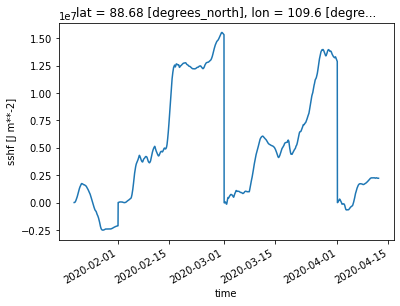

In [54]:
##test if the variables are accumulated
#TP accumulate every month
#slhf accumated every month
# sshf accumulated every month
var='sshf'
test=data[var][:2000,1000]
#[150:420,500]
test.plot()

In [3]:
#creat a output data with all the attribution needed
#Acumunated var slhf, sshf,tp 
#2t, 2d, sst,sp,tp,10u, 10v
var='tp'
#######################

Varout=xr.zeros_like(data[var][0:711,:])
times = pd.date_range("2020/01/20",periods=711,freq='D',closed='left')
time_da = xr.DataArray(times, [('time', times)])

#########
#Output Varout
#########
Varout.coords['time']=time_da

/tmp/ipykernel_4126828/721928097.py:8: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  times = pd.date_range("2020/01/20",periods=711,freq='D',closed='left')


In [4]:
#But fluxes are accumulated from start of every (the) month, or for Jan 2020, it would be Jan 20th. 
#So we need to take the difference from day after to current day. 
####VARarray has the unit from J/s to W/day

#creat a calendar array

yyyys=2020
yyyye=2021
yr=yyyys
#day=4
mms=1
mme=12
cdatearr=[]
dayarr=[]

while yr<=yyyye:
    yyyy=str(yr)
    mth=mms
    if yr==yyyye:
        mthe=mme
    else:
        mthe=12
    while mth<=mthe:
        if mth<10:
            mm='0'+str(mth)
        else:
            mm=str(mth)
        if mth==1 or mth==3 or mth==5 or mth==7 or mth==8 or mth==10 or mth==12:
            daye=31
        elif mth==4 or mth==6 or mth==9 or mth==11:
            daye=30
        if (yr%4)==0 and mth==2:
            daye=29
        elif (yr%4)!=0 and mth==2:
            daye=28
        if yr==2020 and mth==1:
            days=20
        else:
            days=1
        day=days
        tidx=0
        while day<=daye:
            if day<10:
                dd='0'+str(day)
            else:
                dd=str(day)
            cdatearr.append(yyyy+'-'+mm+'-'+dd)
            dayarr.append(day)
            #print(data.str.sel(time=yyyy+'-'+mm+'-'+dd+'T00:00:00.000000000').time)
            day=day+1
            #cidx=cidx+1
        mth=mth+1
    yr=yr+1

print(np.shape(cdatearr)[0]-1)
#print(cdatearr)

711


In [5]:
# day2-day1 = day2_daily

VARarray=[]
cidx=0
while cidx<=np.shape(cdatearr)[0]-2:
    cdate=cdatearr[cidx]
    cdatep=cdatearr[cidx+1]
    #print(dayarr[cidx+1])
    #dlen=len(dayarr[cidx+1])
    if dayarr[cidx+1]==2 or cidx==0: # the first day of a month of the first day of the list
        #print('Use only '+cdatep)
        #print('datestamp='+cdate+'T00:00:00.000000000')
#        VARarray.append(data[var].sel(time=cdatep+'T00:00:00.000000000').reset_coords('time', drop=True) /86400)
        VARarray.append(data[var].sel(time=cdatep+'T00:00:00.000000000').reset_coords('time', drop=True) *1000)

        #print(SHF.max())
    else:
        #print('Use '+cdatep+' - '+cdate)
#        VARarray.append((data[var].sel(time=cdatep+'T00:00:00.000000000')-data[var].sel(time=cdate+'T00:00:00.000000000') )/86400)   
        VARarray.append((data[var].sel(time=cdatep+'T00:00:00.000000000')-data[var].sel(time=cdate+'T00:00:00.000000000') ) *1000)   
        #SHFarray.append(SHF)
    cidx=cidx+1

Varout.data=xr.concat(VARarray,dim='time')
Varout.coords['time']=time_da
#Varout.attrs['units']='W m**-2'
Varout.attrs['units']='mm day**-1'

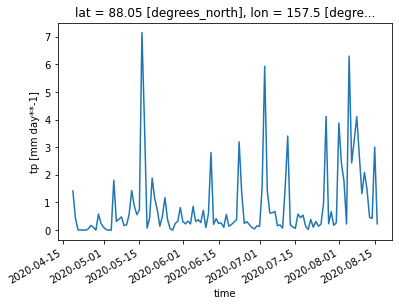

In [6]:
#test the result 
Varout[90:210,2000].plot()

In [7]:
Varout.to_netcdf('/work/bb1153/b381639/IFS/'+var+'_daily_tco1279-orca025.nc')